In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 불러오기
df = pd.read_excel('서울대기오염_2019.xlsx')

# 컬럼 정리
df.columns = ['날짜', '측정소명', '미세먼지', '초미세먼지', '오존', '이산화질소', '일산화탄소', '아황산가스']

# 날짜 정제
df = df[pd.to_datetime(df['날짜'], errors='coerce').notnull()]
df['날짜'] = pd.to_datetime(df['날짜'])

# 결측치 평균으로 대체
df.fillna(df.mean(numeric_only=True), inplace=True)


/tmp/ipykernel_33117/730094581.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = df[pd.to_datetime(df['날짜'], errors='coerce').notnull()]


In [7]:
# 평균 시계열 추출
pm_series = df[df['측정소명'] == '평균'].groupby('날짜')['미세먼지'].mean()

# 정상성 확인 (ADF test)
result = adfuller(pm_series)
print("ADF p-value:", result[1])


ADF p-value: 0.01326704121621125


In [8]:
# ARIMA(1,1,1) 모델 학습
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(pm_series, order=(1,1,1))
model_fit = model.fit()

# 예측 생성
forecast = model_fit.forecast(steps=7)
forecast


/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2020-01-01    30.716697
2020-01-02    33.691843
2020-01-03    35.568473
2020-01-04    36.752193
2020-01-05    37.498847
2020-01-06    37.969813
2020-01-07    38.266884
Freq: D, Name: predicted_mean, dtype: float64

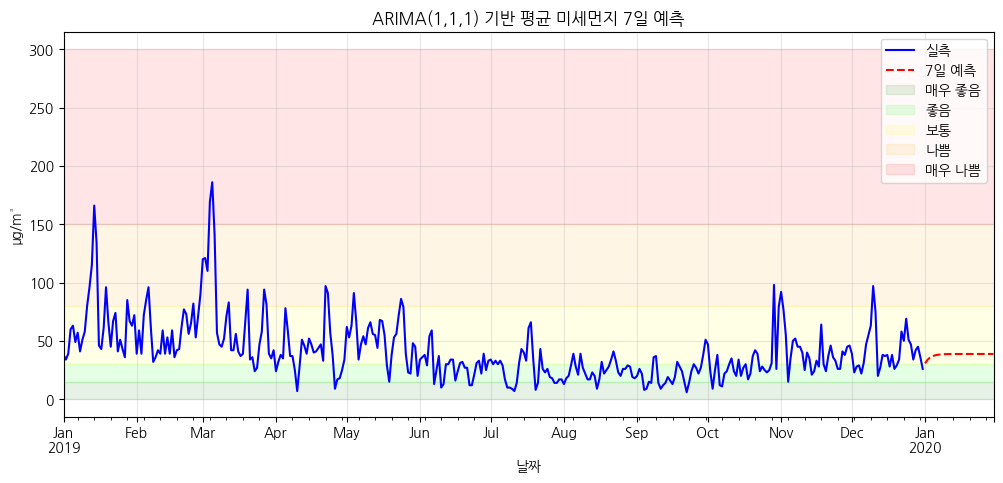

In [13]:
plt.figure(figsize=(12, 5))
pm_series.plot(label='실측', color='blue')
forecast.plot(label='7일 예측', color='red', linestyle='--')
plt.title('ARIMA(1,1,1) 기반 평균 미세먼지 7일 예측')
plt.xlabel('날짜')
plt.ylabel('μg/m³')

# 등급별 구간 색깔 채우기
plt.axhspan(0, 15, color='green', alpha=0.1, label='매우 좋음')
plt.axhspan(15, 30, color='lime', alpha=0.1, label='좋음')
plt.axhspan(30, 80, color='yellow', alpha=0.1, label='보통')
plt.axhspan(80, 150, color='orange', alpha=0.1, label='나쁨')
plt.axhspan(150, 300, color='red', alpha=0.1, label='매우 나쁨')

plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [14]:
# 모델 학습 확인

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 예: 마지막 7일 제외하고 학습
train = pm_series[:-7]
test = pm_series[-7:]

model = ARIMA(train, order=(1,1,1)).fit()
pred = model.forecast(steps=7)

rmse = np.sqrt(mean_squared_error(test, pred))
mae = mean_absolute_error(test, pred)

print("RMSE:", rmse)
print("MAE:", mae)


RMSE: 9.626226441655623
MAE: 8.062504624961775


/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
